In [1]:
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Loading the dataset which is in CSV format
df = pd.read_csv('sample_101_Popular_Spotify_Songs.csv')

# Selecting audio features
features = ['valence_%', 'energy_%', 'danceability_%', 'acousticness_%', 'mode', 'bpm']
df = df.dropna(subset=features + ['streams'])  # Droping missing values that is data cleaning 
df['mode'] = df['mode'].apply(lambda x: 1 if str(x).lower() == 'major' else 0)# converting categorical data into numerical form

# Text preprocessing function using NLP
def preprocess_text(text): # function created
    text = str(text).lower()#converting text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))# Removing punctuation
    text = re.sub(r'\d+', '', text)# Removing numbers 
    text = ' '.join([word for word in text.split() if word not in stop_words])# Removing stop words
    return text

# selects the available text column (lyrics or description), preprocesses it using NLP techniques, and stores the cleaned output for further analysis.
if 'lyrics' in df.columns:
    df['processed_text'] = df['lyrics'].apply(preprocess_text)
elif 'description' in df.columns:
    df['processed_text'] = df['description'].apply(preprocess_text)
else:
    df['processed_text'] = [''] * len(df)  # No text column available

df.head(5)
 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,processed_text
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,1,80,89,83,31,0,8,4,
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,1,71,61,74,7,0,10,4,
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,1,51,32,53,17,0,31,6,
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,1,55,58,72,11,0,11,15,
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,0,65,23,80,14,63,11,6,


In [2]:
# Function to assign mood based on audio features
def assign_mood(row):
    if row['valence_%'] > 65 and row['energy_%'] > 65:
        return 'Happy'
    elif row['valence_%'] < 40 and row['energy_%'] < 50:
        return 'Sad'
    elif row['energy_%'] > 70 and row['danceability_%'] > 60:
        return 'Energetic'
    else:
        return 'Calm'

# Apply the function to create 'mood' column
df['mood'] = df.apply(assign_mood, axis=1)


In [3]:
# If no lyrics or description is given use track_name and artist_name as text
if 'lyrics' in df.columns:
    df['processed_text'] = df['lyrics'].apply(preprocess_text)
elif 'description' in df.columns:
    df['processed_text'] = df['description'].apply(preprocess_text)
else:
    # Combine track_name and artist name as text
    df['processed_text'] = (df['track_name'] + ' ' + df['artist(s)_name']).apply(preprocess_text)

# vectorizing text using TFID
from sklearn.feature_extraction.text import TfidfVectorizer
X_text = TfidfVectorizer(max_features=5000).fit_transform(df['processed_text'])
y_text = df['mood']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

# Train classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

nb = MultinomialNB()
nb.fit(X_train, y_train)

svm = LinearSVC()
svm.fit(X_train, y_train)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("Classifiers trained successfully!")


Classifiers trained successfully!


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def performance_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, average='weighted', zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, average='weighted', zero_division=0), 3),
        "F1-Score": round(f1_score(y_true, y_pred, average='weighted', zero_division=0), 3)
    }
performance_table = pd.DataFrame([
    ["Naive Bayes", *performance_metrics(y_test, y_pred_nb).values()],
    ["SVM", *performance_metrics(y_test, y_pred_svm).values()],
    ["Decision Tree", *performance_metrics(y_test, y_pred_dt).values()]
], columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

print("\nModel Performance Comparison:\n")
print(performance_table)





Model Performance Comparison:

           Model  Accuracy  Precision  Recall  F1-Score
0    Naive Bayes      0.50      0.250    0.50     0.333
1            SVM      0.45      0.392    0.45     0.402
2  Decision Tree      0.35      0.219    0.35     0.269



=== Evaluation Report: SVM Classifier ===

              precision    recall  f1-score   support

        Calm       0.47      0.70      0.56        10
   Energetic       0.50      0.33      0.40         3
       Happy       0.33      0.20      0.25         5
         Sad       0.00      0.00      0.00         2

    accuracy                           0.45        20
   macro avg       0.33      0.31      0.30        20
weighted avg       0.39      0.45      0.40        20



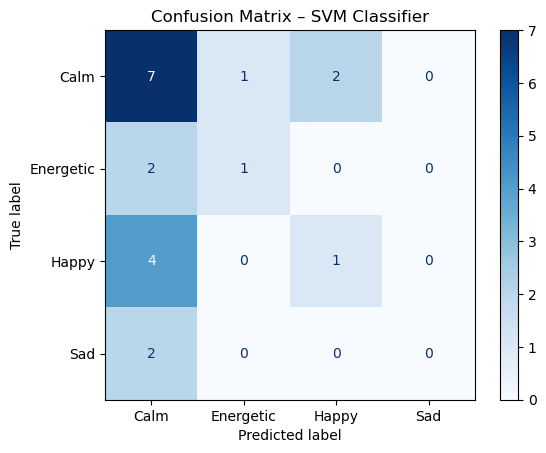

In [30]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("\n=== Evaluation Report: SVM Classifier ===\n")
print(classification_report(
    y_test, 
    y_pred_svm, 
    labels=['Calm', 'Energetic', 'Happy', 'Sad'], 
    zero_division=0
))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_svm,
    display_labels=['Calm', 'Energetic', 'Happy', 'Sad'],
    cmap='Blues'
)

plt.title("Confusion Matrix – SVM Classifier")
plt.show()


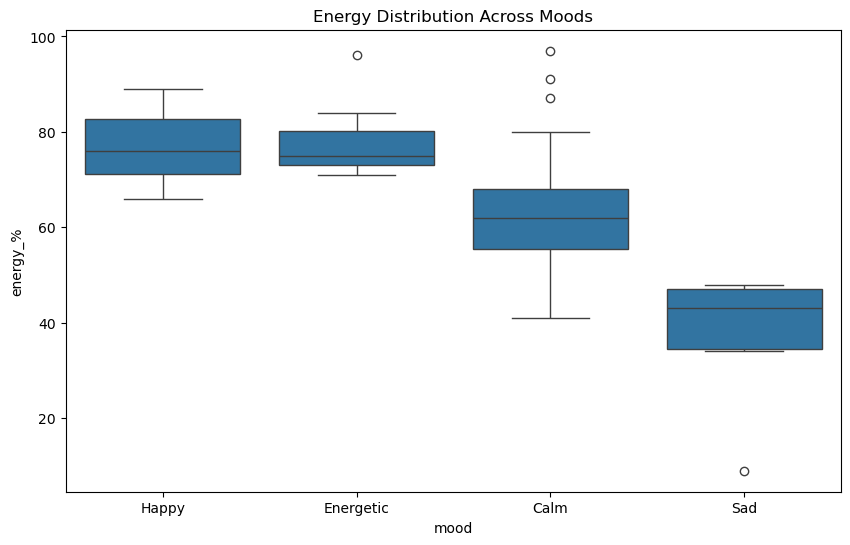

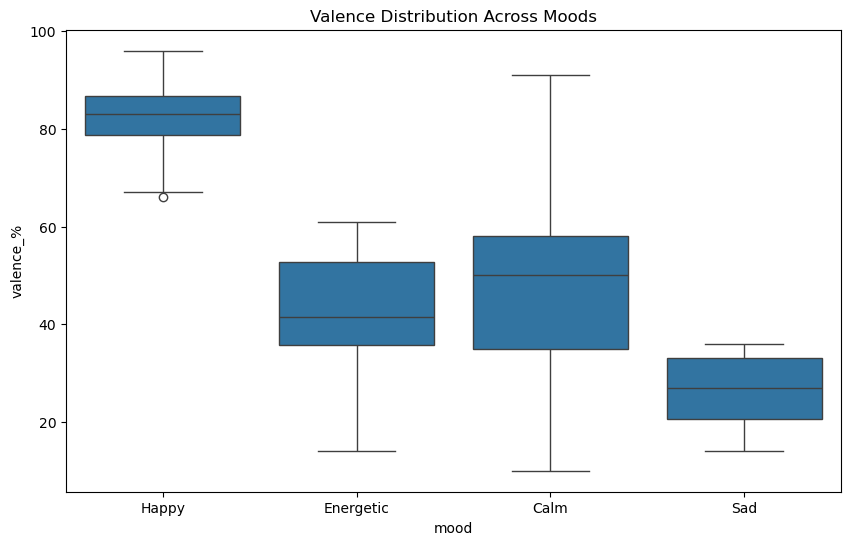

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(x='mood', y='energy_%', data=df)
plt.title('Energy Distribution Across Moods')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='mood', y='valence_%', data=df)
plt.title('Valence Distribution Across Moods')
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Normalizing audio features
scaler = MinMaxScaler()
X_features_scaled = scaler.fit_transform(df[features])

# Computing similarity matrix
similarity_matrix = cosine_similarity(X_features_scaled)

def recommend_by_mood(selected_mood, top_n=5):
    mood_songs = df[df['mood'] == selected_mood].copy()
    mood_songs = mood_songs.sort_values(by='streams', ascending=False)
    top_songs = mood_songs['track_name'].head(top_n).tolist()
    
    print(f"\nMood Selected: {selected_mood}")
    print("Top Songs:")
    for i, song in enumerate(top_songs, 1):
        print(f"{i}. {song}")


In [8]:
def recommend_similar_songs(song_name, top_n=5):
    if song_name not in df['track_name'].values:
        print(f"Song '{song_name}' not found in the dataset.")
        return
    
    idx = df.index[df['track_name'] == song_name][0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]
    
    print(f"\nSong Selected: {song_name}")
    print("Top Similar Songs:")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i}. {df['track_name'].iloc[idx]}")


In [34]:
def recommend_music():
    print("=== Mood & Similarity-Based Music Recommendation ===")
    choice = input("Choose Mood/Text (M/T) or Song Similarity (S): ").strip().upper()

    if choice == 'M' or choice == 'T':
        if choice == 'M':
            mood_input = input("Enter Mood (Happy, Sad, Calm, Energetic): ").capitalize()
            if mood_input not in ['Happy', 'Sad', 'Calm', 'Energetic']:
                print("Invalid mood.")
                return
            recommend_by_mood(mood_input)
        else:
            user_text = input("Enter lyrics or description: ")
            processed = vectorizer.transform([preprocess_text(user_text)])
            
            clf_choice = input("Choose classifier: NaiveBayes (NB), SVM, DecisionTree (DT): ").strip().upper()
            if clf_choice == 'NB':
                mood_pred = nb.predict(processed)[0]
            elif clf_choice == 'SVM':
                mood_pred = svm.predict(processed)[0]
            elif clf_choice == 'DT':
                mood_pred = dt.predict(processed)[0]
            else:
                print("Invalid choice, defaulting to Naive Bayes")
                mood_pred = nb.predict(processed)[0]
            recommend_by_mood(mood_pred)

    elif choice == 'S':
        song_input = input("Enter a song name from the dataset: ")
        recommend_similar_songs(song_input)

    else:
        print("Invalid option. Please choose M, T, or S.")

# Running recommend_music function
recommend_music()

=== Mood & Similarity-Based Music Recommendation ===


Choose Mood/Text (M/T) or Song Similarity (S):  m
Enter Mood (Happy, Sad, Calm, Energetic):  energetic



Mood Selected: Energetic
Top Songs:
1. Sweater Weather
2. Me Porto Bonito
3. Quevedo: Bzrp Music Sessions, Vol. 52
4. Kill Bill
5. Yandel 150
